# This notebook also generates the default param table!
I changed up some of my code to be a bit cleaner, so I'm testing it again on here.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

import os
import numpy as np
import matplotlib.pyplot as plt
import file_loading
from scipy.interpolate import Rbf
from multiprocessing import Pool
from astropy.io import ascii

In [2]:
data_dir = '/home/zequnl/Projects/neutrino_mpk/'
table =  file_loading.get_table( data_dir = data_dir,
                    PS_directory = data_dir + 'powerspectrum_noiseless', 
                    PC_directory = data_dir + 'peakcounts_noiseless',
                    redshift_string = '05')
table.write('parameters.table', format='ascii', overwrite=True)

Found 101 PS files and 101 PC files.


In [7]:
table = ascii.read('parameters.table')
table

Model,M_nu(eV),Omega_m,10^9*A_s,sigma_8(derived),PS,PC
str12,float64,float64,float64,float64,str86,str85
1a(fiducial),0.0,0.3,2.1,0.8523,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50_z05.npy,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S_z05.npy
1b(fiducial),0.1,0.3,2.1,0.8295,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PS_50_z05.npy,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PC_S_z05.npy
2,0.06271,0.3815,2.2004,1.0135,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PS_50_z05.npy,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PC_S_z05.npy
3,0.06522,0.2821,1.8826,0.7563,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PS_50_z05.npy,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PC_S_z05.npy
4,0.06773,0.4159,1.6231,0.9171,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PS_50_z05.npy,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PC_S_z05.npy
5,0.07024,0.2023,2.3075,0.6231,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PS_50_z05.npy,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PC_S_z05.npy
6,0.07275,0.3283,2.2883,0.9324,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PS_50_z05.npy,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PC_S_z05.npy
7,0.07526,0.3355,1.5659,0.7828,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PS_50_z05.npy,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PC_S_z05.npy
8,0.07778,0.2597,2.4333,0.8008,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PS_50_z05.npy,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PC_S_z05.npy


In [5]:
data_dir = '/home/zequnl/Projects/neutrino_mpk/'
params, obsarr_PS, obsarr_PC, ell, kappa, invcov_PS, invcov_PC = \
                file_loading.get_data_arrays_across_redshifts( table, 
                    data_dir = data_dir,                                       
                    PS_directory = data_dir + 'powerspectrum_noiseless', 
                    PC_directory = data_dir + 'peakcounts_noiseless',
                    redshifts = ['05'])

PS bins [24]
PC bins [200]
PS nr 1000 nb 24 0.974974974974975
PC nr 1000 nb 200 0.7987987987987988


LinAlgError: Singular matrix

In [24]:
table

Model,M_nu(eV),Omega_m,10^9*A_s,sigma_8(derived),PS,PC
str12,float64,float64,float64,float64,str86,str85
1a(fiducial),0.0,0.3,2.1,0.8523,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50_z05.npy,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S_z05.npy
1b(fiducial),0.1,0.3,2.1,0.8295,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PS_50_z05.npy,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PC_S_z05.npy
2,0.06271,0.3815,2.2004,1.0135,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PS_50_z05.npy,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PC_S_z05.npy
3,0.06522,0.2821,1.8826,0.7563,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PS_50_z05.npy,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PC_S_z05.npy
4,0.06773,0.4159,1.6231,0.9171,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PS_50_z05.npy,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PC_S_z05.npy
5,0.07024,0.2023,2.3075,0.6231,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PS_50_z05.npy,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PC_S_z05.npy
6,0.07275,0.3283,2.2883,0.9324,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PS_50_z05.npy,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PC_S_z05.npy
7,0.07526,0.3355,1.5659,0.7828,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PS_50_z05.npy,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PC_S_z05.npy
8,0.07778,0.2597,2.4333,0.8008,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PS_50_z05.npy,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PC_S_z05.npy


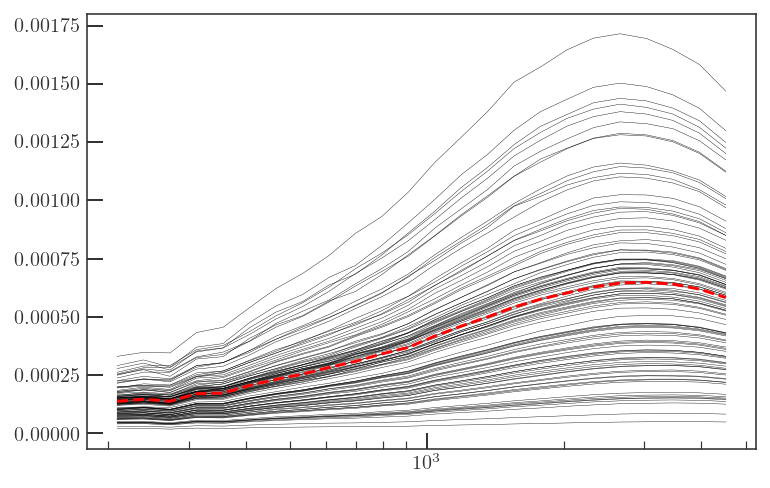

In [19]:

    
for i in range(101):
    plt.plot(ell, ell**2 * obsarr_PS[i], 'k-', lw=0.2)
plt.xscale('log')

plt.plot(ell, ell**2 * obsarr_PS[1], 'r--')

# plt.yscale('log')

In [22]:
from forecast import build_interp_zack

# set up interpolator
interp_PS = build_interp_zack(obsarr_PS, params)
interp_PC = build_interp_zack(obsarr_PC, params)


In [26]:
def P_PS( parameter_input ):
    mu = interp_PS( parameter_input )
    d = obsarr_PS[1] # use first 
    dm = d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(invcov_PS,dm)) )

def P_PC( parameter_input ):
    mu = interp_PC( parameter_input )
    d = obsarr_PC[1] # use first 
    dm = d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(invcov_PC,dm)) )

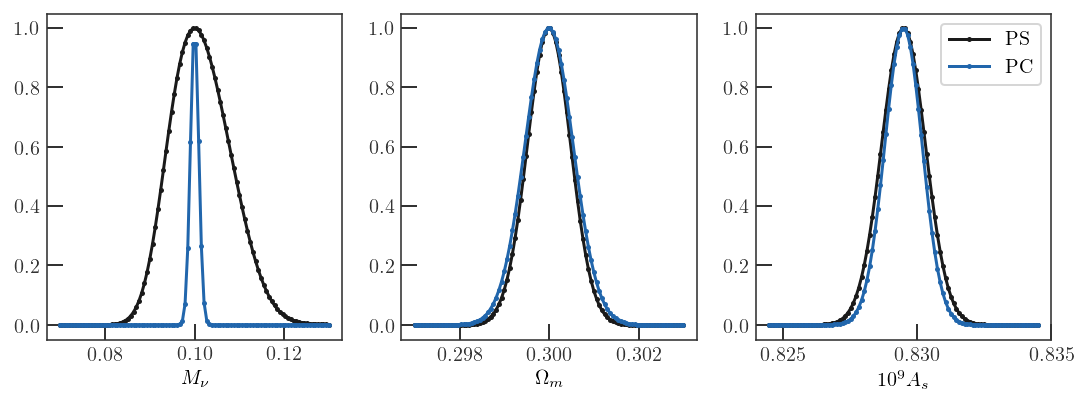

In [29]:
u = np.linspace(0.1 - 0.03, 0.1 + 0.03, 100)
v = np.linspace(0.3 - 0.003, 0.3 + 0.003, 100)
w = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, 100)

fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot( u, [P_PS( (p, 0.3, 0.8295)) for p in u] )
ax[0].set_xlabel(r'$M_{\nu}$')
ax[1].plot( v, [P_PS( (0.1, p, 0.8295) ) for p in v] )
ax[1].set_xlabel(r'$\Omega_m$')
ax[2].plot( w, [P_PS( (0.1, 0.3, p) ) for p in w], label='PS' )
ax[2].set_xlabel(r'$10^9A_s$')

ax[0].plot( u, [P_PC( (p, 0.3, 0.8295)) for p in u] )
ax[0].set_xlabel(r'$M_{\nu}$')
ax[1].plot( v, [P_PC( (0.1, p, 0.8295) ) for p in v] )
ax[1].set_xlabel(r'$\Omega_m$')
ax[2].plot( w, [P_PC( (0.1, 0.3, p) ) for p in w], label='PC' )
ax[2].set_xlabel(r'$10^9A_s$')
ax[2].legend()


CPU times: user 16.1 s, sys: 20 ms, total: 16.1 s
Wall time: 16.2 s


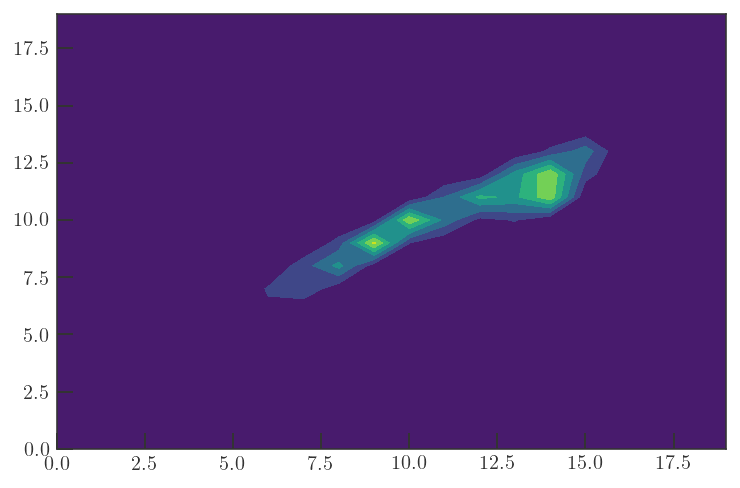

In [33]:
%%time

nres = 20
x = np.linspace(0.1 - 0.03*3, 0.1 + 0.03*3, nres)
y = np.linspace(0.3 - 0.003*3, 0.3 + 0.003*3, nres)
z = np.linspace(2.1 - 0.01*3, 2.1 + 0.01*3, nres)

X, Y, Z = np.meshgrid(x, y, z)
PS_cube = [P_PS( (x,y,z) ) for \
           x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))]
PS_cube = np.array(PS_cube)
PS_cube = PS_cube.reshape(X.shape)

plt.contourf( np.sum(PS_cube, axis=2) )

CPU times: user 21.8 s, sys: 388 ms, total: 22.2 s
Wall time: 2min 14s


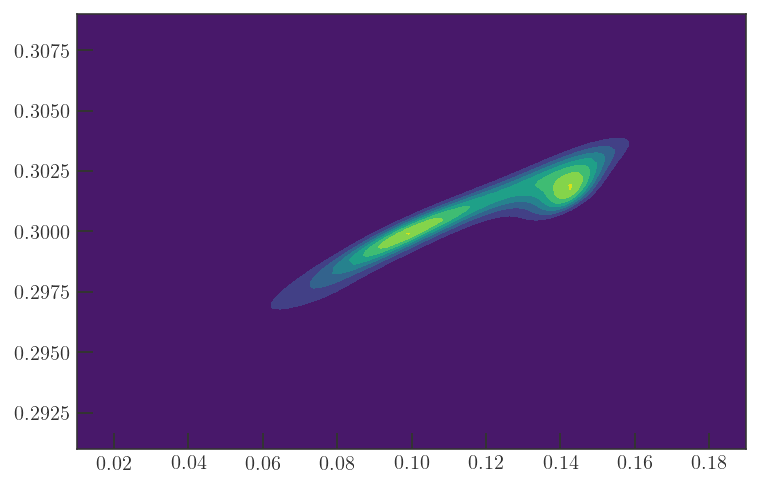

In [34]:
%%time
if __name__ == '__main__':
    pool = Pool(16)

    nres = 100
    x = np.linspace(0.1 - 0.03*3, 0.1 + 0.03*3, nres)
    y = np.linspace(0.3 - 0.003*3, 0.3 + 0.003*3, nres)
    z = np.linspace(2.1 - 0.01*3, 2.1 + 0.01*3, nres)

    X, Y, Z = np.meshgrid(x, y, z)

    input_param_list = zip(np.ravel(X), np.ravel(Y), np.ravel(Z))
    PS_cube = pool.map(P_PS, input_param_list)
    PS_cube = np.array(PS_cube)
    PS_cube = PS_cube.reshape(X.shape)

    plt.contourf( x, y, np.sum(PS_cube, axis=2) )
    pool.close()

In [35]:
from forecast import build_interp_zack

data_dir = '/home/zequnl/Projects/neutrino_mpk/'
table = ascii.read('parameters.table')

params, obsarr_PS, obsarr_PC, ell, kappa, invcov_PS, invcov_PC = \
                file_loading.get_data_arrays_across_redshifts( table,
                    data_dir = data_dir,
                    PS_directory = data_dir + 'old_data/powerspectrum', 
                    PC_directory = data_dir + 'old_data/peakcounts',
                    redshifts = ['05', '10', '15', '20'])

# set up interpolator
interp_PS = build_interp_zack(obsarr_PS, params)
interp_PC = build_interp_zack(obsarr_PC, params)

def P_PS( parameter_input ):
    my_interp = interp_PS; 
    my_invcov = invcov_PS;
    my_fid_model = obsarr_PS[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )

def P_PC( parameter_input ):
    my_interp = interp_PC; 
    my_invcov = invcov_PC;
    my_fid_model = obsarr_PC[1]
    
    dm = my_fid_model - my_interp( parameter_input ) # d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(my_invcov,dm)) )


PS nr 1000 nb 96 0.9029029029029029
PC nr 1000 nb 575 0.42342342342342343


CPU times: user 3.94 s, sys: 232 ms, total: 4.18 s
Wall time: 2min 21s


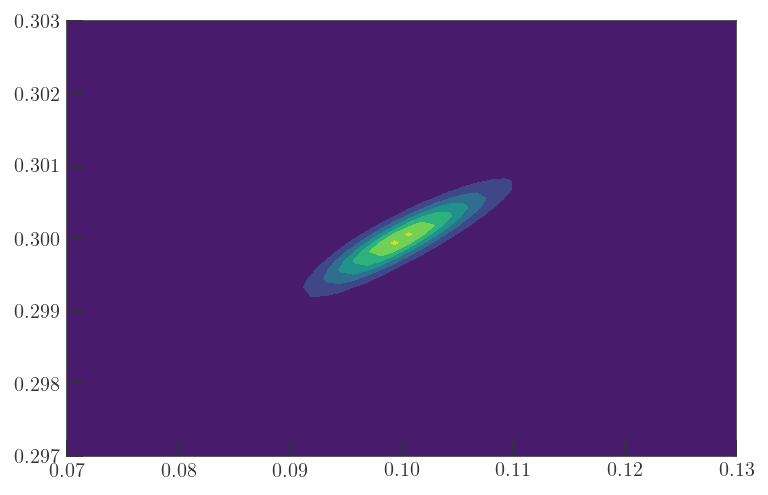

In [36]:
%%time
if __name__ == '__main__':
    pool = Pool(16)

    nres = 50
    x = np.linspace(0.1 - 0.03, 0.1 + 0.03, nres)
    y = np.linspace(0.3 - 0.003, 0.3 + 0.003, nres)
    z = np.linspace(2.1 - 0.01, 2.1 + 0.01, nres)

    X, Y, Z = np.meshgrid(x, y, z)

    input_param_list = zip(np.ravel(X), np.ravel(Y), np.ravel(Z))
    PS_cube = pool.map(P_PS, input_param_list)
    PS_cube = np.array(PS_cube)
    PS_cube = PS_cube.reshape(X.shape)

    plt.contourf( x, y, np.sum(PS_cube, axis=2) )
    pool.close()

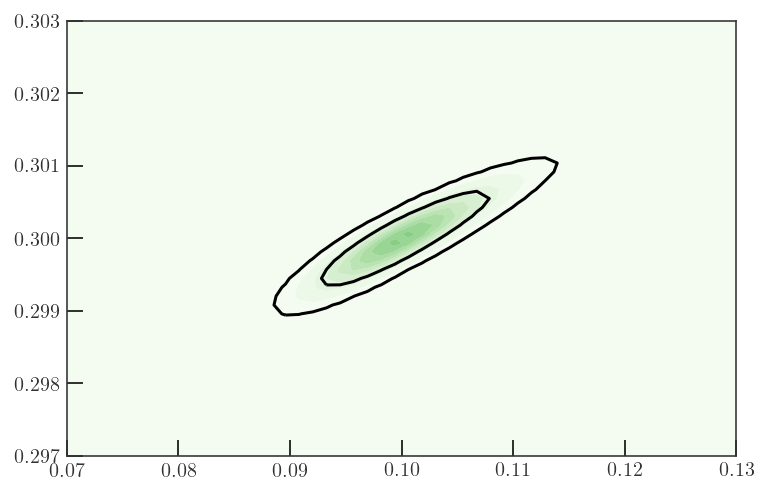

In [37]:
from forecast import findlevel

tot = np.sum(PS_cube.flatten())
mid = np.mean(PS_cube.flatten()) * 20
flattened = np.sum(PS_cube, axis=2) / tot
c_68, c_95, c_99 = findlevel(flattened)

plt.contourf( x, y, flattened, cmap=plt.cm.Greens, levels=np.linspace(0.,mid,20) )
plt.contour( x, y, flattened, levels=[c_95, c_68], \
                     colors=('black'))


In [69]:
tt = np.load( 'peakcounts_noisy/Om0.33625_As2.47811_mva0.08320_mvb0.08364_mvc0.09726_h0.70000_Ode0.65789_PC_S_z11000.npy' )

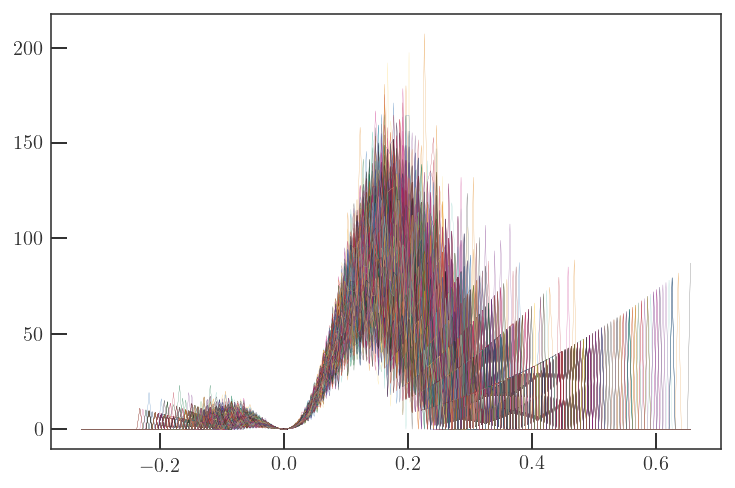

In [71]:
kappa = tt[0,:]
realizations = tt[2:,:]
for i in range(len(realizations)):
    plt.plot( kappa, kappa**2 * realizations[i,:], '-', lw=0.1 )
# plt.xlim(0,5000)

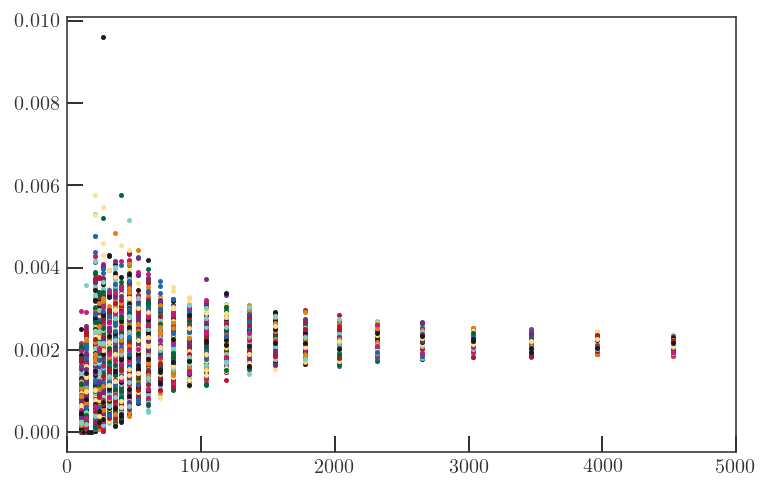

In [60]:
PS_arr = np.load('powerspectrum_noisy/Om0.18159_As1.79315_mva0.02743_mvb0.02874_mvc0.05735_h0.70000_Ode0.81586_PS_50_z11000.npy')

ell = PS_arr[0,:]
PS_realizations = PS_arr[1:,:]
for i in range(len(PS_realizations)):
    plt.plot( ell, ell**2 * PS_realizations[i,:], '.', lw=0.1 )
    plt.xlim(0,5000)

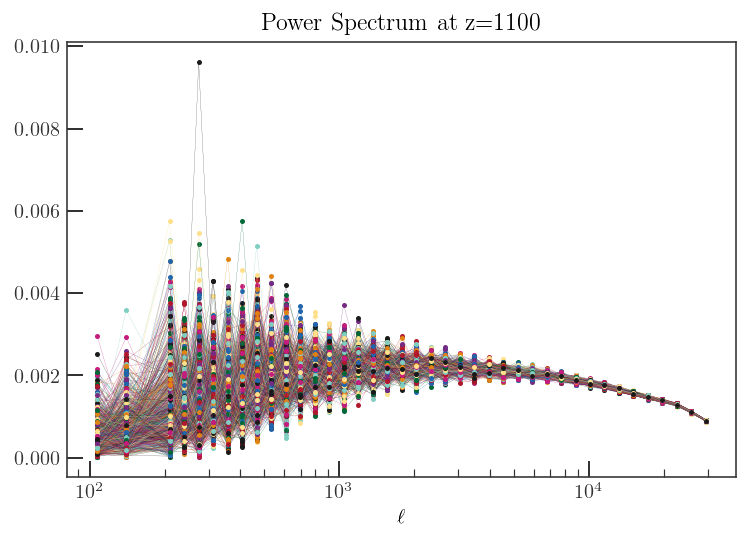

In [3]:
PS_arr = np.load('powerspectrum_noisy/Om0.18159_As1.79315_mva0.02743_mvb0.02874_mvc0.05735_h0.70000_Ode0.81586_PS_50_z11000.npy')
bad_filt = np.logical_not(np.isclose(np.mean( PS_arr[1:,:], axis=0 ),0.0,rtol=0.,atol=1e-12))

ell = PS_arr[0,:]
PS_arr = ((PS_arr.T)[bad_filt]).T
ell = ell[bad_filt]
PS_realizations = PS_arr[1:,:]

for i in range(len(PS_realizations)):
    plt.plot( ell, ell**2 * PS_realizations[i,:], '.-', lw=0.1 )
    
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.title('Power Spectrum at z=1100')

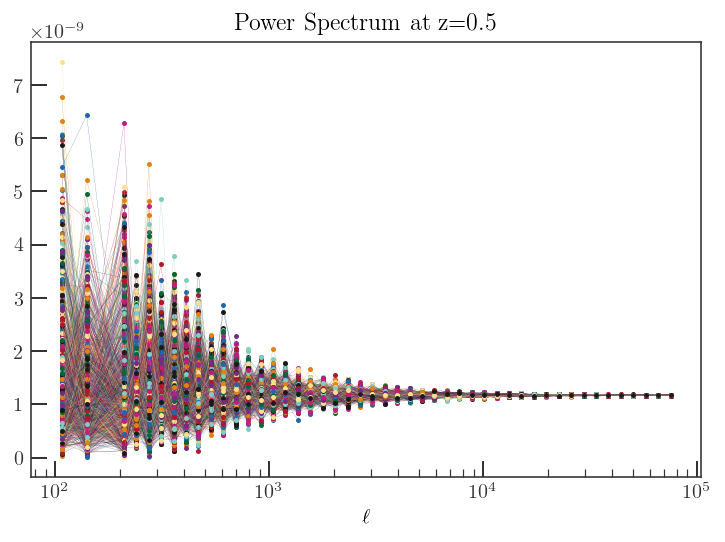

In [5]:
PS_arr = np.load('powerspectrum_noisy/Om0.18159_As1.79315_mva0.02743_mvb0.02874_mvc0.05735_h0.70000_Ode0.81586_PS_50_z05.npy')
bad_filt = np.logical_not(np.isclose(np.mean( PS_arr[1:,:], axis=0 ),0.0,rtol=0.,atol=1e-12))

ell = PS_arr[0,:]
PS_arr = ((PS_arr.T)[bad_filt]).T
ell = ell[bad_filt]
PS_realizations = PS_arr[1:,:]

for i in range(len(PS_realizations)):
    plt.plot( ell,  PS_realizations[i,:], '.-', lw=0.1 )
    
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.title('Power Spectrum at z=0.5')

In [65]:
PS_arr = np.load('powerspectrum_noisy/Om0.18159_As1.79315_mva0.02743_mvb0.02874_mvc0.05735_h0.70000_Ode0.81586_PS_50_z11000.npy')
bad_filt = np.logical_not(np.isclose(np.mean( PS_arr[1:,:], axis=0 ),0.0))

ell = PS_arr[0,:]
ell[bad_filt]

array([ 107.15204885,  139.99872454,  209.0785494 ,  238.98534938,
        273.17004724,  312.24455768,  356.90832427])

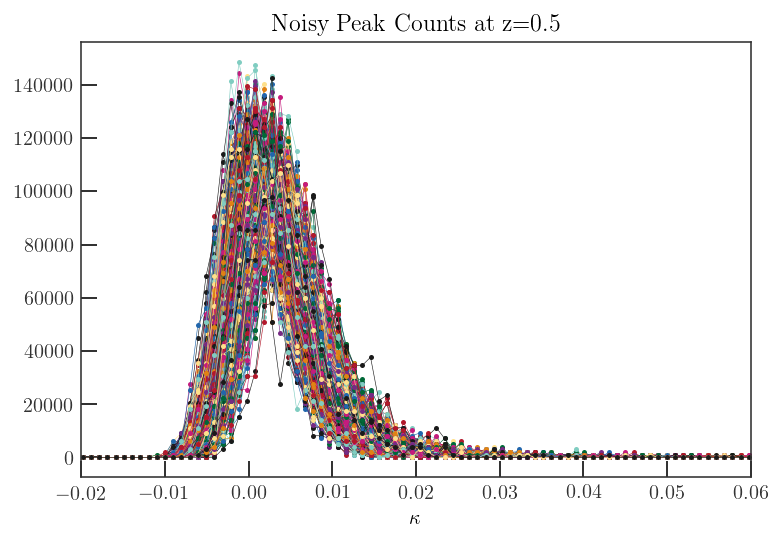

In [41]:
PS_arr = np.load('peakcounts_noiseless/Om0.18159_As1.79315_mva0.02743_mvb0.02874_mvc0.05735_h0.70000_Ode0.81586_PC_S_z10.npy')
bad_filt = np.logical_not(np.isclose(np.mean( PS_arr[1:,:], axis=0 ),0.0,rtol=0.,atol=1e-12))

ell = PS_arr[0,:]
PS_realizations = PS_arr[2:,:]


for i in range(1000):
    plt.plot( ell,  PS_realizations[i,:], '.-', lw=0.3 )
    
# plt.xscale('log')
plt.xlim(-0.02, 0.06)
plt.xlabel(r'$\kappa$')
plt.title('Noisy Peak Counts at z=0.5')

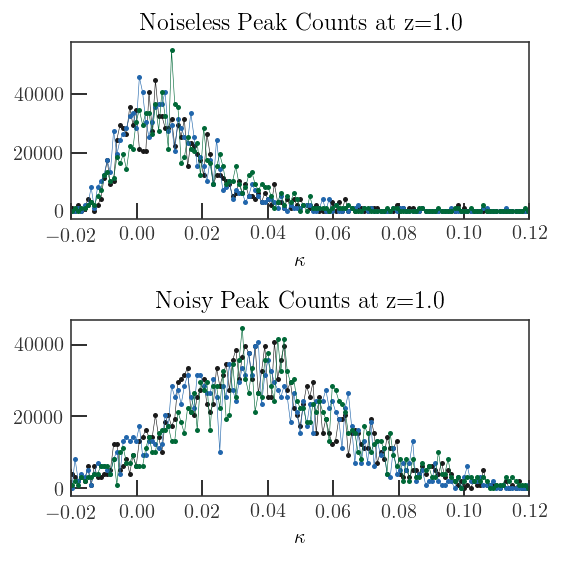

In [72]:
PS_arr = np.load('peakcounts_noisy/Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S_z10.npy')
bad_filt = np.logical_not(np.isclose(np.mean( PS_arr[1:,:], axis=0 ),0.0,rtol=0.,atol=1e-12))

ell = PS_arr[0,:]
PS_realizations = PS_arr[2:,:]

fig, ax = plt.subplots(2,1,figsize=(4,4))

for i in range(3):
    ax[1].plot( ell,  PS_realizations[i,:], '.-', lw=0.3 )
    
# plt.xscale('log')
ax[1].set_xlim(-0.02, 0.12)
ax[1].set_xlabel(r'$\kappa$')
ax[1].set_title('Noisy Peak Counts at z=1.0')

PS_arr = np.load('peakcounts_noiseless/Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S_z10.npy')
bad_filt = np.logical_not(np.isclose(np.mean( PS_arr[1:,:], axis=0 ),0.0,rtol=0.,atol=1e-12))

ell = PS_arr[0,:]
PS_realizations = PS_arr[2:,:]


for i in range(3):
    ax[0].plot( ell,  PS_realizations[i,:], '.-', lw=0.3 )
    
# plt.xscale('log')
ax[0].set_xlim(-0.02, 0.12)
ax[0].set_xlabel(r'$\kappa$')
ax[0].set_title('Noiseless Peak Counts at z=1.0')

plt.tight_layout()
fig.savefig('figures/fig_effect_of_noise_PC.pdf')

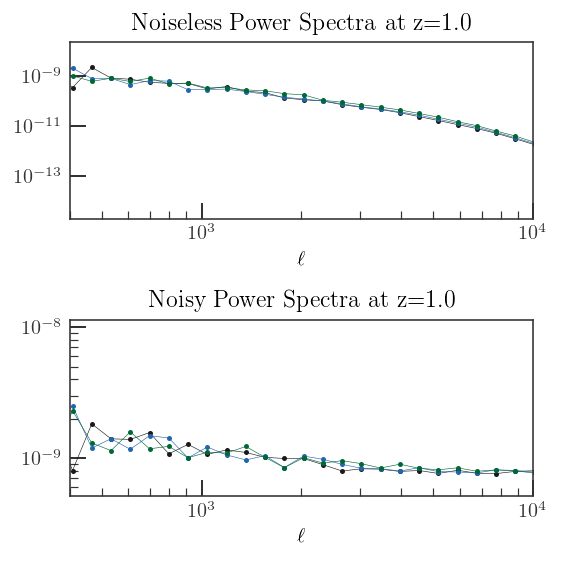

In [73]:
PS_arr = np.load('powerspectrum_noisy/Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50_z10.npy')
bad_filt = np.logical_not(np.isclose(np.mean( PS_arr[1:,:], axis=0 ),0.0,rtol=0.,atol=1e-12))

ell = PS_arr[0,:]
PS_realizations = PS_arr[1:,:]

fig, ax = plt.subplots(2,1,figsize=(4,4))

for i in range(3):
    ax[1].plot( ell,  PS_realizations[i,:], '.-', lw=0.3 )
    
# plt.xscale('log')
# ax[0].set_xlim(-0.02, 0.12)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(400,1e4)
# ax[0].set_ylim(1e-13,1e-8)
ax[1].set_xlabel(r'$\ell$')
ax[1].set_title('Noisy Power Spectra at z=1.0')

PS_arr = np.load('powerspectrum_noiseless/Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50_z10.npy')
bad_filt = np.logical_not(np.isclose(np.mean( PS_arr[1:,:], axis=0 ),0.0,rtol=0.,atol=1e-12))

ell = PS_arr[0,:]
PS_realizations = PS_arr[1:,:]


for i in range(3):
    ax[0].plot( ell,  PS_realizations[i,:], '.-', lw=0.3 )
    
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(400,1e4)
# ax[1].set_ylim(1e-13,1e-8)
ax[0].set_xlabel(r'$\ell$')
ax[0].set_title('Noiseless Power Spectra at z=1.0')

plt.tight_layout()
fig.savefig('figures/fig_effect_of_noise_PS.pdf')